## IV. Methodology

### 4.1 Dataset Preparation
* Load the clean EEG, EOG, and EMG data from the EEGDenoiseNet dataset in .npy format.
* Randomly select a clean EEG segment (2-second duration) from the dataset.
* Randomly select an EOG or EMG artifact segment from the respective dataset.
### 4.2 SNR Generation
* Determine the desired range of SNR values to evaluate for both ocular and myogenic artifacts. For example, consider the ranges mentioned in the paper: ocular artifacts (-7 to 2 dB) and myogenic artifacts (-7 to 4 dB).
* Randomly select an SNR value from the respective range for each contaminated signal.
### 4.3 Contaminated Signal Generation
For each selected clean EEG segment:
* Randomly select an artifact type (EOG or EMG).
* Randomly select an artifact segment from the chosen type.
* Calculate the contaminated signal using the formula: contaminated_signal = clean_eeg + λ * artifact_segment.
* Adjust the value of λ based on the randomly selected SNR value.
### 4.4 Denoising Methods
#### 4.4.1 Independent Component Analysis
* Apply ICA to the contaminated EEG signal to extract independent components.
* Identify the components representing the EEG signal.
* Reconstruct the denoised EEG signal using the selected components.
* Measure the processing time and SNR of the denoised signal.
#### 4.4.2 Empirical Mode Decomposition
* Apply EMD to the contaminated EEG signal to decompose it into intrinsic mode functions (IMFs).
* Analyze the IMFs to identify and remove artifacts or noise components.
* Reconstruct the denoised EEG signal using the remaining IMFs.
* Measure the processing time and SNR of the denoised signal.
### 4.5 Evaluation
* Calculate the SNR of the denoised EEG signals using appropriate metrics such as the ratio of signal power to noise power.
* Compare the SNR performance and processing time of ICA and EMD for denoising the EEG signals.
* Analyze the results and draw conclusions regarding the denoising effectiveness and efficiency of each method.

### 4.1 Dataset Preparation

In [5]:
import numpy as np
eeg = np.load('EEGDenoiseNet/EEG_all_epochs.npy')
print(f"------EEG-----\nSize: {eeg.size}\nRow count: {len(eeg)}\nColumn count: {len(eeg[0])}\nFirst Column: {eeg[:, 0]}\n\n")

emg = np.load('EEGDenoiseNet/EMG_all_epochs.npy')
print(f"------EMG(Heart)-----\nSize: {emg.size}\nRow count: {len(emg)}\nColumn count: {len(emg[0])}\nFirst Column: {emg[:, 0]}\n\n")

eog = np.load('EEGDenoiseNet/EOG_all_epochs.npy')
print(f"------EOG(Ocular)-----\nSize: {eog.size}\nRow count: {len(eog)}\nColumn count: {len(eog[0])}\nFirst Column: {eog[:, 0]}")

------EEG-----
Size: 2311168
Row count: 4514
Column count: 512
First Column: [184.5070843  171.96198926 229.56731921 ... 317.59704985 262.89154388
 216.07429779]


------EMG(Heart)-----
Size: 2866176
Row count: 5598
Column count: 512
First Column: [20245.96672667 23595.64263225 34991.76745427 ...  1490.61150022
   -38.705385    1260.54203952]


------EOG(Ocular)-----
Size: 1740800
Row count: 3400
Column count: 512
First Column: [  7.30828446  -1.68701752  12.4808031  ...   6.81209745 298.19922839
 -44.54226777]


In [6]:
import matplotlib.pyplot as plt

def plot_random_row(dataset, title:str):
    num_rows, num_columns = dataset.shape
    sampling_rate = 256  # Hz
    duration = 2  # seconds
    time = np.arange(0, duration, 1/sampling_rate)

    #----PLOT RANDOM ROW AS SAMPLE-----
    random_row_index = np.random.randint(num_rows) #produce random index or number
    random_row = dataset[random_row_index] #extract row of that corresponding index
    plt.plot(time, random_row)
    plt.title(f'{title} Dataset Row #{random_row_index} (random)')
    return plt.show()

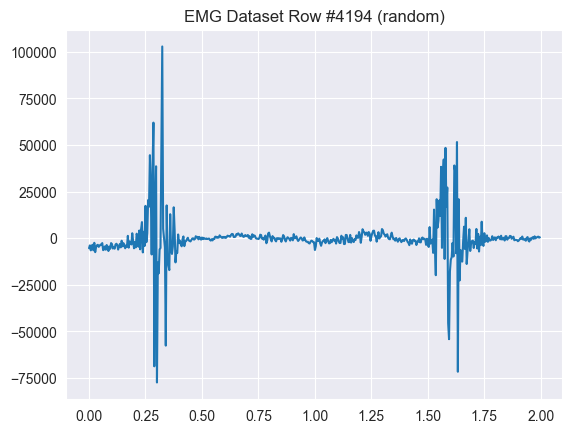

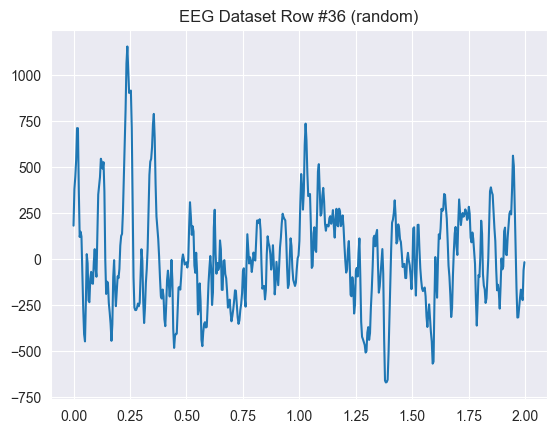

In [7]:
plot_random_row(emg,'EMG')
plot_random_row(eeg,'EEG')

### 4.2 SNR Generation

* Randomly select an SNR value from the respective range for each contaminated signal.

Ocular artifacts: [-7 to 2]
Mygoenic artifact: [-7 to 4]

What I did for this part is every time I create a contaminated EEG signal, a random SNR value is chosen. I did not pick specific SNR values anymore as increasing or decreasing SNR value doesn't necessarily mean it's more complex.

### 4.3 Contaminated Signal Generation

In [8]:
print(len(eeg[1]))
print(eeg[1][0])

512
171.96198926000247


In [9]:
# # #RMS
# # #g is 1 sample of EEG data. n is the 512 columns
# def rms(eeg_index):
#     #n = number of samples
#     #summation of g^2
#     sum=0
#     for i in range(512):
#         sum+=(eeg[eeg_index][i])**2
#     return ((1/512)*sum)**0.5
#
#
# # #SNR
# # import math
# # def snr()
# #     z = rms()
# #     math.log10(z)

**WHAT'S WRONG?**

* Delta should be used in the code instead of SNR.
* Delta should be adjusted based on the SNR value you want
* It should be: ```contaminated_eeg_sample = clean_eeg_sample + delta*eog_artifact```

ADD CODE TO DETERMINE THE DELTA BASED ON THE RANDOMLY GENERATED SNR VALUE.

$$\text{SNR} = 10log\frac{RMS(x)}{RMS(\lambda\times n)}$$


$$\frac{SNR}{10} = log\frac{RMS(x)}{RMS(\lambda\times n)}$$

$$SNR=10\log\frac{\text{RMS(signal)}}{RMS(noise)}$$

In [10]:
# ## ATTEMPT 2 OF FUNCTION GENERATE_CONTAMINATED_EEG_DATA | WITH CONTAMINATION INDICES
#
# def generate_contaminated_eeg_data(clean_eeg_data, artifacts, num_samples, artifact_type:str):
#     num_clean_eeg_samples = clean_eeg_data.shape[0]
#     num_artifacts = artifacts.shape[0]
#
#     contaminated_eeg_data = []
#     contamination_indices = []
#     snr_values = []
#     if artifact_type=='eog':
#         max_snr = 2+1
#     elif artifact_type=='emg':
#         max_snr=4+1
#
#     for _ in range(num_samples):
#         snr = np.random.randint(-7, max_snr)
#         clean_eeg_index = np.random.randint(0, num_clean_eeg_samples)
#         artifact_index = np.random.randint(0, num_artifacts)
#
#         clean_eeg_sample = clean_eeg_data[clean_eeg_index]
#         eog_artifact = artifacts[artifact_index]
#         contaminated_eeg_sample = clean_eeg_sample + snr*eog_artifact
#
#         contaminated_eeg_data.append(contaminated_eeg_sample)
#         contamination_indices.append((clean_eeg_index, artifact_index))
#         snr_values.append(snr)
#
#     return np.array(contaminated_eeg_data), contamination_indices,snr_values

In [11]:
num_samples = 1000  # Specify the number of contaminated EEG data samples to generate
contaminated_eeg_data, contamination_indices,snr_values = generate_contaminated_eeg_data(eeg, eog, num_samples,artifact_type='eog')

# Verify the shape of the generated contaminated EEG data
print("Shape of contaminated EEG data:", contaminated_eeg_data.shape)

NameError: name 'generate_contaminated_eeg_data' is not defined

In [ ]:
# Print the indices of the clean EEG data and EOG artifacts used for each contaminated signal
#for i, (eeg_index, eog_index) in enumerate(contamination_indices):
#    print(f"Contaminated EEG sample {i+1}: Clean EEG index = {eeg_index}, EOG index = {eog_index}")
#print(contamination_indices)

sampling_rate = 256  # Hz
duration = 2  # seconds
time = np.arange(0, duration, 1/sampling_rate)

plt.figure(figsize=(10, 6))
row=0

# Plot clean EEG
plt.subplot(2, 2, 1)
plt.plot(time, eeg[contamination_indices[row][0]])  # Replace '0' with the desired segment or row from the clean EEG data
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Clean EEG (row: {contamination_indices[row][0]})')

# Plot EOG
plt.subplot(2, 2, 2)
plt.plot(time, eog[contamination_indices[row][1]])  # Replace '0' with the desired segment or row from the EOG data
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'EOG (row: {contamination_indices[row][1]})')

# Plot contaminated signal
plt.subplot(2, 1, 2)
plt.plot(time, contaminated_eeg_data[row])  # Replace '0' with the desired segment or row from the contaminated signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Contaminated Signal | $snr={snr_values[row]}$')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_snr(clean_eeg, artifact_segment,λ):
    N = 512
    # Calculate the signal power (clean EEG)
    signal_power = (np.sum(clean_eeg ** 2)*(1/N))**0.5
    # Calculate the noise power (artifact segment)
    noise_power = (np.sum((λ*artifact_segment)**2)*(1/N))**0.5
    # Calculate the SNR in dB (RMS FORMULA)
    snr_db = 10 * np.log10(signal_power / noise_power)
    return round(snr_db,2)

def generate_contaminated_signal(clean_eeg_data,artifact_data,num_samples:int, artifact_type:str):
    num_clean_eeg_samples = clean_eeg_data.shape[0]
    num_eog_artifacts = artifact_data.shape[0]

    contaminated_eeg_data = []
    contamination_indices = []
    snr_values=[]

    for i in range(num_samples):
        clean_eeg_index = np.random.randint(0, num_clean_eeg_samples)
        eog_artifact_index = np.random.randint(0, num_eog_artifacts)

        clean_eeg_sample = clean_eeg_data[clean_eeg_index]
        artifact = artifact_data[eog_artifact_index]

        #GENERATE RANDOM LAMBDA VALUE HERE
        λ = random.uniform(-1,1)
        print(λ)

        #GENERATE CONTAMINATED SIGNAL USING FORMULA: y=x+(λ*n)
        contaminated_eeg_sample = clean_eeg_sample + (artifact*λ)

        contaminated_eeg_data.append(contaminated_eeg_sample)
        contamination_indices.append((clean_eeg_index, eog_artifact_index))
        snr_values.append(calculate_snr(clean_eeg_data,artifact,λ))
    return np.array(contaminated_eeg_data), contamination_indices, snr_values, artifact_type

def get_random_rows(dataset, num_rows):
    num_total_rows = dataset.shape[0]
    selected_indices = np.random.choice(num_total_rows, size=num_rows, replace=False)
    selected_rows = dataset[selected_indices, :]
    return selected_rows

#----------------
clean_eeg_data = get_random_rows(eeg,1000)
artifact_data = get_random_rows(eog,1000)
λ = 0.3
for i in [0.1,0.2,0.3,0.4]:
    λ=i
    contaminated_eeg_data = clean_eeg_data + λ * artifact_data
    # Calculate SNR for each contaminated EEG sample
    snr_values = calculate_snr(contaminated_eeg_data, clean_eeg_data, artifact_data)

    # Verify the shape of the SNR values array
    print(f"\n\n-----| {λ} |-----")
    print("Shape of SNR values:", snr_values.shape)
    # Example: print SNR values for the first 10 contaminated EEG samples
    print(f"SNR values for the first 10 samples: {round(snr_values[0]),round(snr_values[1]),round(snr_values[2]),round(snr_values[3]),round(snr_values[4]),round(snr_values[5]),round(snr_values[6]),round(snr_values[7]),round(snr_values[8]),round(snr_values[9])}")
    print(f"Max SNR: {round(max(snr_values))}\nMin SNR: {round(min(snr_values))}\nAverage SNR: {round(np.mean(snr_values))}")

Ocular artifacts: [-7 to 2] Mygoenic artifact: [-7 to 4]



| λ   | Max | Min | AVG | SNR values of first 10 samples           |
|-----|-----|-----|-----|------------------------------------------|
| 0.1 | 42  | 9   | 26  | (25, 33, 26, 38, 28, 31, 37, 35, 23, 26) |
| 0.2 | 37  | 1   | 20  | (27, 16, 23, 20, 17, 14, 20, 22, 12, 24) |
| 0.3 | 32  | -1  | 17  | (16, 24, 17, 28, 18, 22, 28, 26, 14, 17)                                         |
| 0.4 | 31  | -9  | 14  | (18, 16, 2, 10, 17, 3, 22, 13, 9, 7)     |
| 0.5 | 30  | -7  | 12  | (9, 18, 6, 8, 15, 9, 6, 10, 11, 11)      |
| 0.6 | 26  | -7  | 11  | (10, 18, 11, 22, 12, 16, 22, 20, 8, 11)                                         |
| 0.7 | 25  | -8  | 9   | (8, 16, 9, 21, 11, 14, 20, 18, 6, 9)                                         |
| 0.8 | 24  | -9  | 8   | (7, 15, 8, 20, 10, 13, 19, 17, 5, 8)                                         |
| 0.9 | 23  | -10 | 7   | (6, 14, 7, 19, 9, 12, 18, 16, 4, 7)                                         |
| 1   | 22  | -11 | 6   | (5, 13, 6, 18, 8, 11, 17, 15, 3, 6)                                         |
| 1.1 | 23  | -13 | 5   | (1, 4, -2, 3, -1, 23, -3, 2, 9, 3)                                         |
| 1.2 | 22  | -13 | 4   | (1, 3, -3, 2, -1, 22, -4, 1, 8, 2)                                         |
| 1.3 | 22  | -14 | 4   | (0, 2, -3, 1, -2, 22, -4, 0, 7, 1)                                         |
| 1.4 | 21  | -15 | 3   | (-1, 2, -4, 1, -3, 21, -5, 0, 7, 1)                                         |
| 1.5 | 21  | -15 | 2   | (-1, 1, -5, 0, -3, 21, -6, -1, 6, 0)                                         |
| 1.6 | 20  | -16 | 2   | (-2, 1, -5, 0, -4, 20, -6, -2, 6, 0)                                         |
| 1.7 | 19  | -16 | 1   | (-2, 0, -6, -1, -4, 19, -7, -2, 5, -1)                                         |
| 1.8 | 19  | -17 | 1   | (-3, -1, -6, -1, -5, 19, -7, -3, 5, -1)                                         |
| 1.9 | 18  | -17 | 0   | (-3, -1, -7, -2, -5, 18, -8, -3, 4, -2)                                         |
| 2.0 | 18  | -18 | 0   | (-4, -1, -7, -2, -6, 18, -8, -3, 4, -2)                                         |


**TASKS** - July 27, 2023

* ~Function that calculates RMS and SNR of an array of signals~

* ~Function that generates contaminated signal~
    * ~Parameters~:
        * ~clean eeg dataset~
        * ~artifact segment dataset~
        * ~string: 'ocular' or 'myogenic'~
        * ~sample size (number of contaminated signals to be generated)~
    * ~Functionalities:~
        * ~Randomly generate decimal lambda values ranging from 0 to 1.6~
        * ~Creates contaminated signal from clean eeg and artifact using the formula given.~
        * ~Calculate the snr of that given signal using the SNR function.~
    * ~Returns:~
        * ~NP array(nx512): contaminated_eeg_data~
        * ~List: contamination_indices (clean_eeg_index, artifact_index)~
        * ~List: snr_values~
        * ~string: artifact_type~

* ~The output of the functions above shall be assigned to variables: contaminated, indices, snr_values~
* ~Print out the shape of the dataset.~
* ~CODE that filters generated contaminated signals (whether they fall within the accepted range of SNR values for that artifact type)~
    * ~Variables:~
        *  ~contaminated, indices, snr_values, artifact_type~
    * ~Functionalities:~
        * ~if artifact_type=='ocular', snr_range=[-7,2+1]; elif artifact_type=='myogenic', snr_range=[-7,4+1]~
        * ~Go through contaminated2 & snr_values2 and see if that row has a snr value that satisfies the given snr_range~
            * ~If false: delete row using the index~

* ~Then create new variables, contaminated2, indices2, and snr_values2.~

In [ ]:
import random
import numpy as np

def get_random_rows(dataset, num_rows):
    num_total_rows = dataset.shape[0]
    selected_indices = np.random.choice(num_total_rows, size=num_rows, replace=False)
    selected_rows = dataset[selected_indices, :]
    return selected_rows

#CALCULATES SNR INDIVIDUALLY; GOOD FOR THE SIGNAL GENERATION FUNCTION


In [ ]:
import random
import numpy as np

def calculate_snr(clean_eeg, artifact_segment,λ):
    N = 512
    # Calculate the signal power (clean EEG)
    signal_power = (np.sum(clean_eeg ** 2)*(1/N))**0.5
    # Calculate the noise power (artifact segment)
    noise_power = (np.sum((λ*artifact_segment)**2)*(1/N))**0.5
    # Calculate the SNR in dB (RMS FORMULA)
    snr_db = 10 * np.log10(signal_power / noise_power)
    return round(snr_db,2)

def generate_contaminated_signal(clean_eeg_data,artifact_data,num_samples:int, artifact_type:str):
    num_clean_eeg_samples = clean_eeg_data.shape[0]
    num_eog_artifacts = artifact_data.shape[0]

    contaminated_eeg_data = []
    contamination_indices = []
    snr_values=[]

    for i in range(num_samples):
        clean_eeg_index = np.random.randint(0, num_clean_eeg_samples)
        eog_artifact_index = np.random.randint(0, num_eog_artifacts)

        clean_eeg_sample = clean_eeg_data[clean_eeg_index]
        artifact = artifact_data[eog_artifact_index]

        #GENERATE RANDOM LAMBDA VALUE HERE
        λ = random.uniform(-40,40)
        #GENERATE CONTAMINATED SIGNAL USING FORMULA: y=x+(λ*n)
        contaminated_eeg_sample = clean_eeg_sample + (artifact*λ)
        snr=calculate_snr(clean_eeg_data,artifact,λ)

        contaminated_eeg_data.append(contaminated_eeg_sample)
        contamination_indices.append((clean_eeg_index, eog_artifact_index))
        snr_values.append(snr)
    return np.array(contaminated_eeg_data), contamination_indices, snr_values, artifact_type

In [ ]:
contaminated_eeg_data,indices,snr_values,artifact_type = generate_contaminated_signal(eeg,eog,100000,'ocular')
print(f"{contaminated_eeg_data}\nSNR Values: {snr_values}\nArtifact Type: {artifact_type}")

In [ ]:
count=0
contaminated_data2,indices2,snr_values2 = [],[],[]
if artifact_type =='ocular':
    snr_range = [-7,2]
elif artifact_type == 'myogenic':
    snr_range = [-7,4]

for i in snr_values:
    if i>=snr_range[0] and i<=snr_range[1]:
        index=snr_values.index(i)
        count+=1
        contaminated_data2.append(contaminated_eeg_data[index])
        indices2.append(indices[index])
        snr_values2.append(snr_values[index])

print(count)

### 4.4 Denoising Methods

In [ ]:
# from PyEMD import EMD
#
# contaminated_data2=np.array(contaminated_data2)
# # Create an instance of the EMD class
# emd = EMD()
#
# # Decompose the contaminated EEG data using Empirical Mode Decomposition
# # `emd.sift()` returns a list of IMFs (Intrinsic Mode Functions) and a residue
# imfs=emd.emd(contaminated_data2)
#
# # Combine the IMFs to reconstruct the denoised EEG data
# #denoised_eeg_data = np.sum(imfs, axis=0)
#
# # Now you have the denoised EEG data in 'denoised_eeg_data'

#### 4.4.1 Empirical Mode Decomposition

1. Apply the EMD algorithm on the contaminated data. The output of this are several IMFs.
2. Reconstruction: After obtaining the IMFs, you can reconstruct the original EEG signal by summing all the IMFs and the residual component (the last component after the EMD process). The reconstructed signal should closely resemble the original EEG data, with any artifacts or noise removed.
3. SNR (Deconstructed vs original contaminated signal).
4. Visual Inspection
5. Performance Metrics: Memory, Time, MSE
6. Cross-Validation: To ensure the results are robust and not dependent on a specific subset of the data, consider performing cross-validation by splitting your dataset into training and testing sets or using k-fold cross-validation.

In [ ]:
contaminated_data2

In [ ]:
from PyEMD import EMD
sampling_rate = 256  # Hz
duration = 2  # seconds

#DEFINE SIGNAL
t = np.arange(0, duration, 1/sampling_rate)
s = contaminated_data2[0]

emd = EMD(DTYPE=np.float16, max_imfs=2)
IMF = EMD().emd(s,t)
N = IMF.shape[0]+1

# Plot results
plt.subplot(N,1,1)
plt.plot(t, s, 'r')
#plt.title("Input signal: $S(t)=cos(22\pi t^2) + 6t^2$")
plt.title("Input signal")
plt.xlabel("Time [s]")

for n, imf in enumerate(IMF):
    plt.subplot(N,1,n+2)
    plt.plot(t, imf, 'g')
    plt.title("IMF "+str(n+1))
    plt.xlabel("Time [s]")

plt.tight_layout()
plt.savefig('simple_example')
plt.show()

In [ ]:
def apply_emd(contaminated_datasets, sampling_rate=256, duration=2, max_imfs=2):
    """
    Applies Empirical Mode Decomposition (EMD) to a list of contaminated EEG datasets.

    Parameters:
        contaminated_datasets (list): A list of contaminated EEG datasets, where each row represents a single EEG signal.
        sampling_rate (int): Sampling rate of the EEG signals in Hz. Default is 256 Hz.
        duration (float): Duration of each EEG signal in seconds. Default is 2 seconds.
        max_imfs (int): Maximum number of Intrinsic Mode Functions (IMFs) to be computed. Default is 2.

    Returns:
        list: A list of lists containing the Intrinsic Mode Functions (IMFs) for each row in the input dataset.
    """
    IMF_list = []

    # Loop through every row of the given dataset
    for s in contaminated_datasets:
        # Create time array for the signal
        t = np.arange(0, duration, 1/sampling_rate)

        # Create an instance of EMD with specific settings
        emd = EMD(DTYPE=np.float16, max_imfs=max_imfs)

        # Perform EMD on the current row
        IMF = emd.emd(s, t)

        # Add the list of IMFs for the current row to the IMF_list
        IMF_list.append(IMF)

    return IMF_list


In [ ]:
IMFs = apply_emd(contaminated_data2)

In [ ]:
print(len(IMFs))

In [ ]:
# #STEP 2: RECONSTRUCTION
# reconstructed_signal = np.sum(IMF, axis=0) + residual
#
# # STEP 3: CALCULATE SNR
#
# # STEP 4: VISUAL INSPECTION
# # Plot the original EEG signal, the IMFs, and the reconstructed signal
#
# # STEP 5: PERFORMANCE METRICS
#
# # STEP 6: CROSS-VALIDATION

#### 4.4.2 Independent Component Analysis